In [1]:
import sys,os
sys.path.append(os.path.abspath("../../"))
sys.path.append(os.path.abspath('../../modules/'))
import healpy as h
from modules.flat_sky_codes import tangent_plane_analysis as tpa
from modules.flat_sky_codes import flat_sky_analysis as fsa
from modules.masking import gen_masks as gm
from modules.settings import global_mmf_settings as gset
from data_preprocess import tiling_the_sphere as tts

%pylab notebook

def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

figpath="../../../../../documents/automated_cluster_detection/figures/"

ensure_dir(figpath)

Populating the interactive namespace from numpy and matplotlib


In [2]:
dataset="planck_pr3"
whichch="hfi"
mask_point_sources=False
numprocs=35

if whichch=="allch":
    chmin=30.
elif whichch=="hfi":
    chmin=100.

use_psf_data=True
ps_suffix="_inpainted_data"
if mask_point_sources:
    use_psf_data=False
    ps_suffix="_masked_data"
    
    
figstamp=dataset + "_" + whichch + ps_suffix
dir_suffix=whichch + ps_suffix

save_results=False
run_analysis=False

figstamp,dir_suffix

outpath="/results/" + dataset + "/planck_cosmo_cat_" + dir_suffix + "/"
tempdatapath="/tempdata/" + dataset + "/planck_cosmo_cat/"
gset.setup_mmf_config(dataset=dataset,outpath=outpath,tempdatapath=tempdatapath,chmin=chmin,xsize=15.,do_band_pass=True,use_psf_data=use_psf_data)
figpath=gset.mmfset.paths["result_figs"]

In [3]:
tts.gset.mmfset.xsize

15.0

In [15]:
cat=tts.return_tile_definition()
gal_mask=tts.return_zone_mask(nside=512)

In [8]:
fmap,fsky_map,apo_mask=tts.return_sky_tile_map(edge_width=60.,fwhm=60.)

<IPython.core.display.Javascript object>


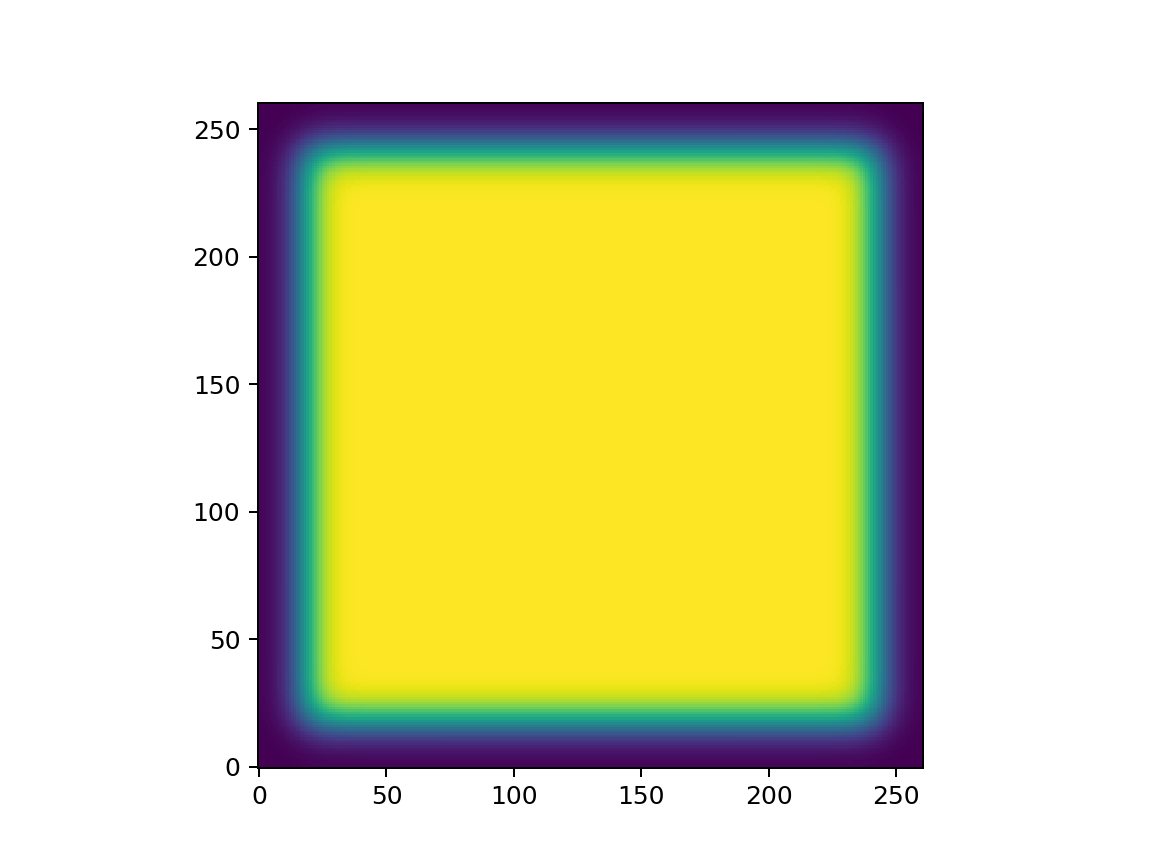

In [9]:
tmap=np.ones_like(apo_mask)
tmap[apo_mask<0.99]=0
figure()
imshow(apo_mask,origin="lower")

In [10]:
fsky_map[fsky_map>=0.3]=1.
fsky_map[fsky_map<0.3]=0.
sum(fsky_map)

702.0

<IPython.core.display.Javascript object>


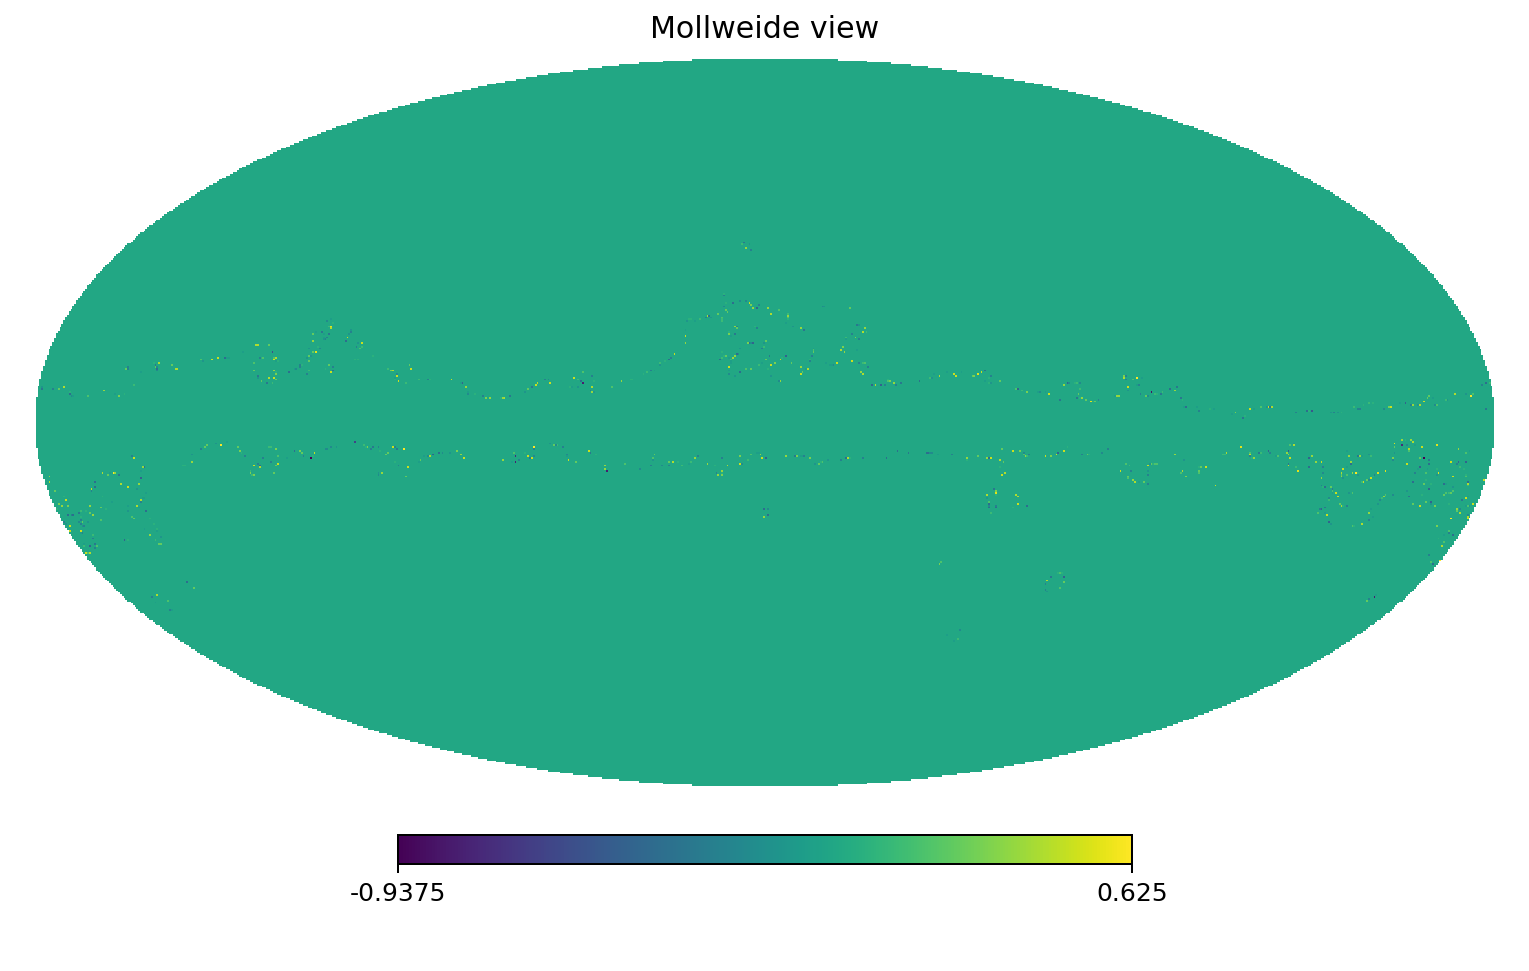

In [16]:
tmap=np.ones_like(fmap)
tmap[fmap<1.]=0
h.mollview(tmap-gal_mask)

In [130]:
def return_edge_apodized_mask(npix,reso,edge_width=17.,fwhm=20.):
	mask=np.ones((npix,npix),float)
	epix=np.int(np.ceil(edge_width/reso))
	mask[:epix,:]=0 ; mask[npix-epix:,:]=0
	mask[:,:epix]=0 ; mask[:,npix-epix:]=0
	ell,bl=fsa.get_gauss_beam(fwhm,20000)
	mask=fsa.filter_map(mask,reso,bl,ell)
	return mask

NSIDE = 2048
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


<IPython.core.display.Javascript object>


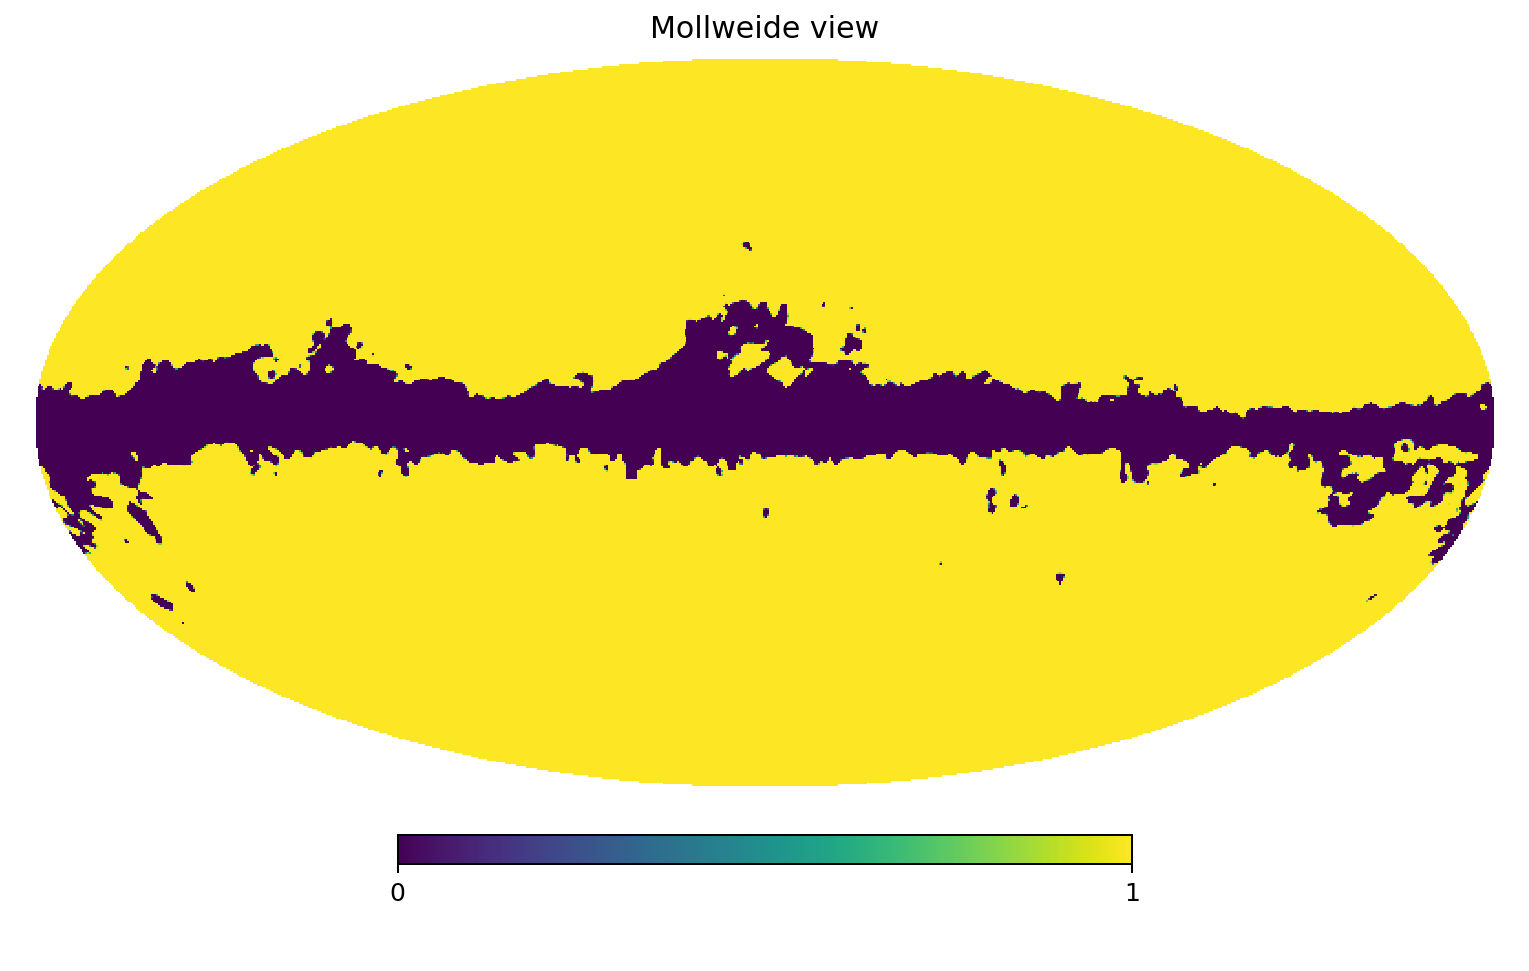

In [270]:
mask=h.read_map("/Users/adityarotti/Documents/Work/Data/Planck/masks/COM_Mask_PCCS-143-zoneMask_2048_R2.01.fits")
mask=(2-mask)/2.

nside=512
mask=h.ud_grade(mask,nside)

h.mollview(mask)


# Masking the LMC and SMC

In [271]:
lmc_glon=280.4652
lmc_glat=-32.8884
lmc_pix=h.ang2pix(nside,lmc_glon,lmc_glat,lonlat=True)
lmc_vec=h.pix2vec(nside,lmc_pix)
lmc_pix=h.query_disc(nside,lmc_vec,radius=(2*60./60.)*np.pi/180.)
mask[lmc_pix]=0.

smc_glon=302.8084 
smc_glat=-44.3277
smc_pix=h.ang2pix(nside,smc_glon,smc_glat,lonlat=True)
smc_vec=h.pix2vec(nside,smc_pix)
smc_pix=h.query_disc(nside,smc_vec,radius=(1.5*60./60.)*np.pi/180.)
mask[smc_pix]=0.

<IPython.core.display.Javascript object>


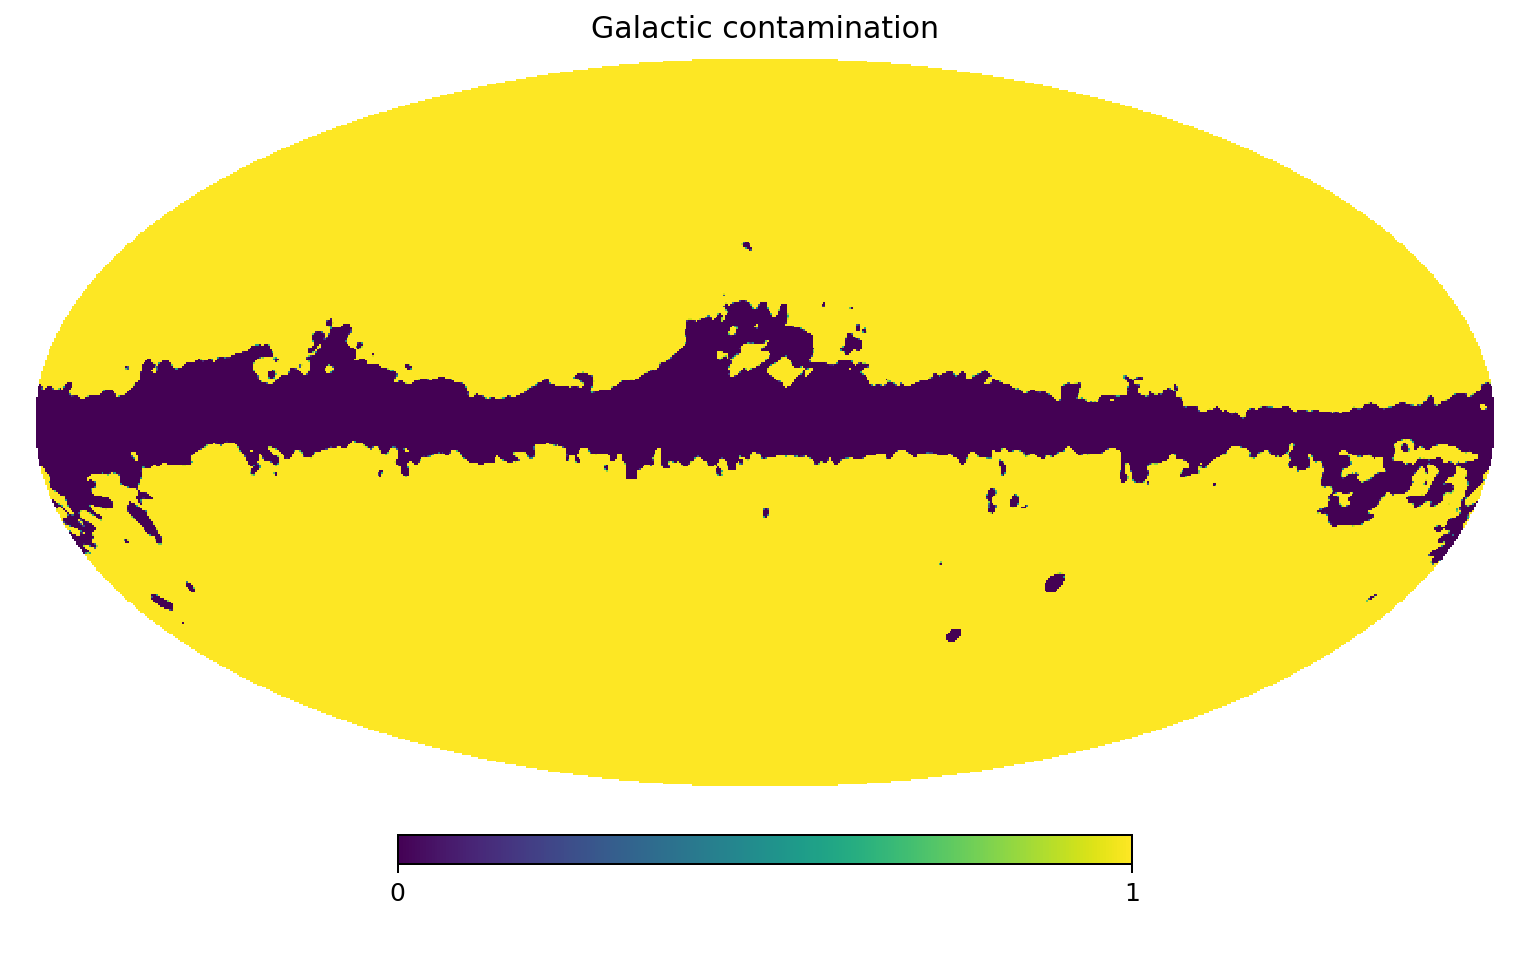

In [272]:
h.mollview(mask,title="Galactic contamination")
filename=figpath + "gal_cont_mask.pdf"
savefig(filename,bbox_inches="tight")

In [287]:
gset.mm

In [291]:
x,y=np.indices((projop.npix,projop.npix))

In [274]:
fmap=np.zeros(h.nside2npix(nside),float)
mask=h.ud_grade(mask,nside)

tilenside=8
pixnum=arange(h.nside2npix(tilenside))
fsky=np.zeros(np.size(pixnum),float)
pix_glon,pix_glat=h.pix2ang(tilenside,pixnum,lonlat=True)

xsize=18.

idx=0
projop=tpa.tangent_plane_setup(nside,xsize,pix_glat[idx],pix_glon[idx],rescale=0.5)
apo_mask=return_edge_apodized_mask(projop.npix,projop.pixel_size,edge_width=60.,fwhm=60.)
apo_mask[apo_mask<=0.99]=0.

timage=projop.get_tangent_plane(tmap)
timage[:,:]=1.
x,y=np.indices((timage.shape))

tmap=np.zeros(h.nside2npix(nside),float)
for idx in pixnum:
    projop=tpa.tangent_plane_setup(nside,xsize,pix_glat[idx],pix_glon[idx],rescale=0.5)
    glon,glat=projop.ij2ang(x.ravel(),y.ravel())
    mapixs=h.ang2pix(nside,glon,glat,lonlat=True)
    tmap[:]=0.
    tmask=projop.get_tangent_plane(mask)
    fsky[idx]=np.sum(tmask)/np.size(tmask)
    tmap[mapixs]=(apo_mask*tmask).ravel()
    fmap=fmap+tmap


    
# glat_thr=0.
# for idx in pixnum[(fsky>0.0) & (abs(pix_glat)>glat_thr)]:
# #for idx in pixnum[(fsky>0.3) & (abs(cglat)>glat_thr)]:
# # for idx in pixnum[(fsky>0.3)][0:1]:
#     projop=tpa.tangent_plane_setup(nside,xsize,pix_glat[idx],pix_glon[idx],rescale=0.2)
#     tmap[:]=0.
#     glon,glat=projop.ij2ang(x.ravel(),y.ravel())
#     mapixs=h.ang2pix(nside,glon,glat,lonlat=True)
#     tmap[mapixs]=apo_mask.ravel()
#     fmap=fmap+tmap

<IPython.core.display.Javascript object>


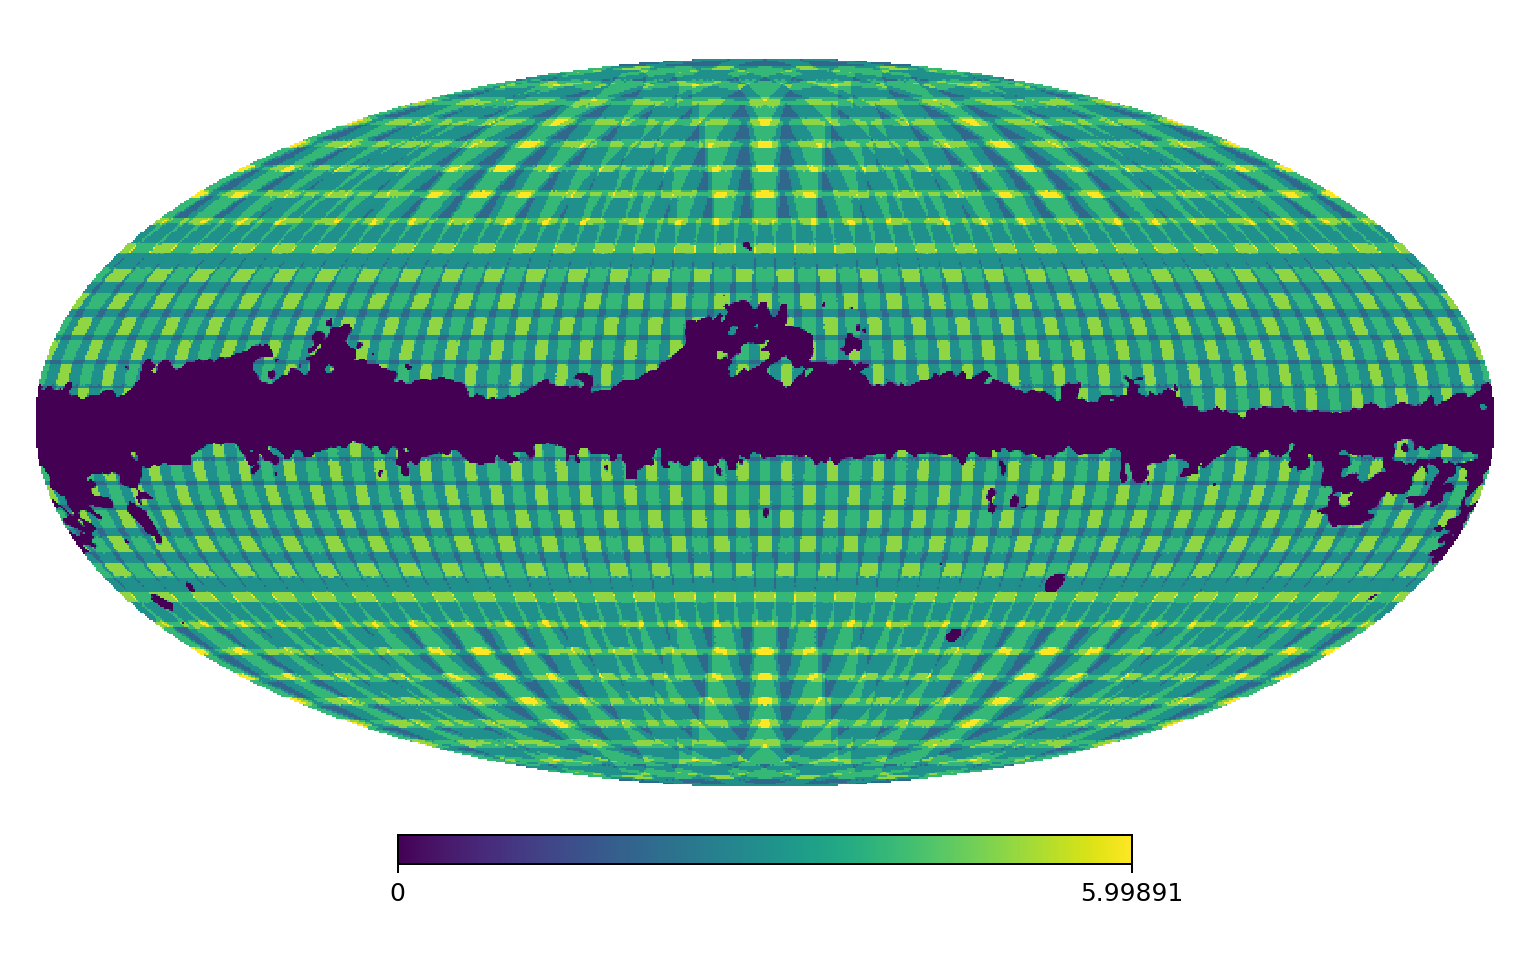

In [276]:
h.mollview(fmap,title="",rot=(0,0))
filename=figpath + "tiled_sky.pdf"
savefig(filename,bbox_inches="tight")

<IPython.core.display.Javascript object>


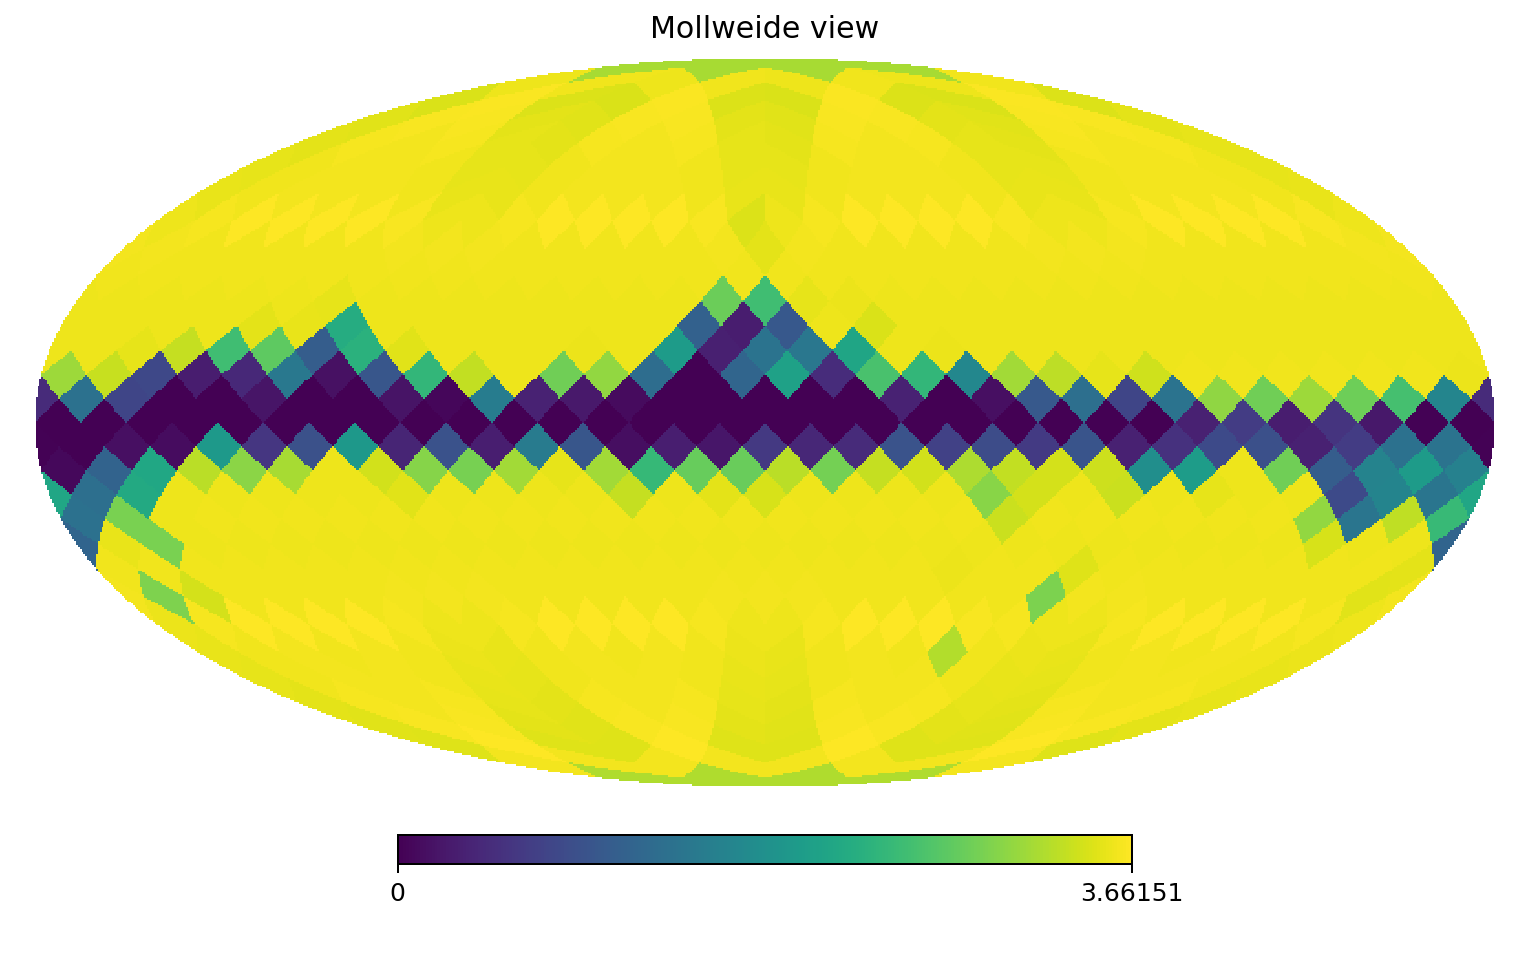

In [277]:
h.mollview(h.ud_grade(fmap,8),rot=(0,0))

<IPython.core.display.Javascript object>


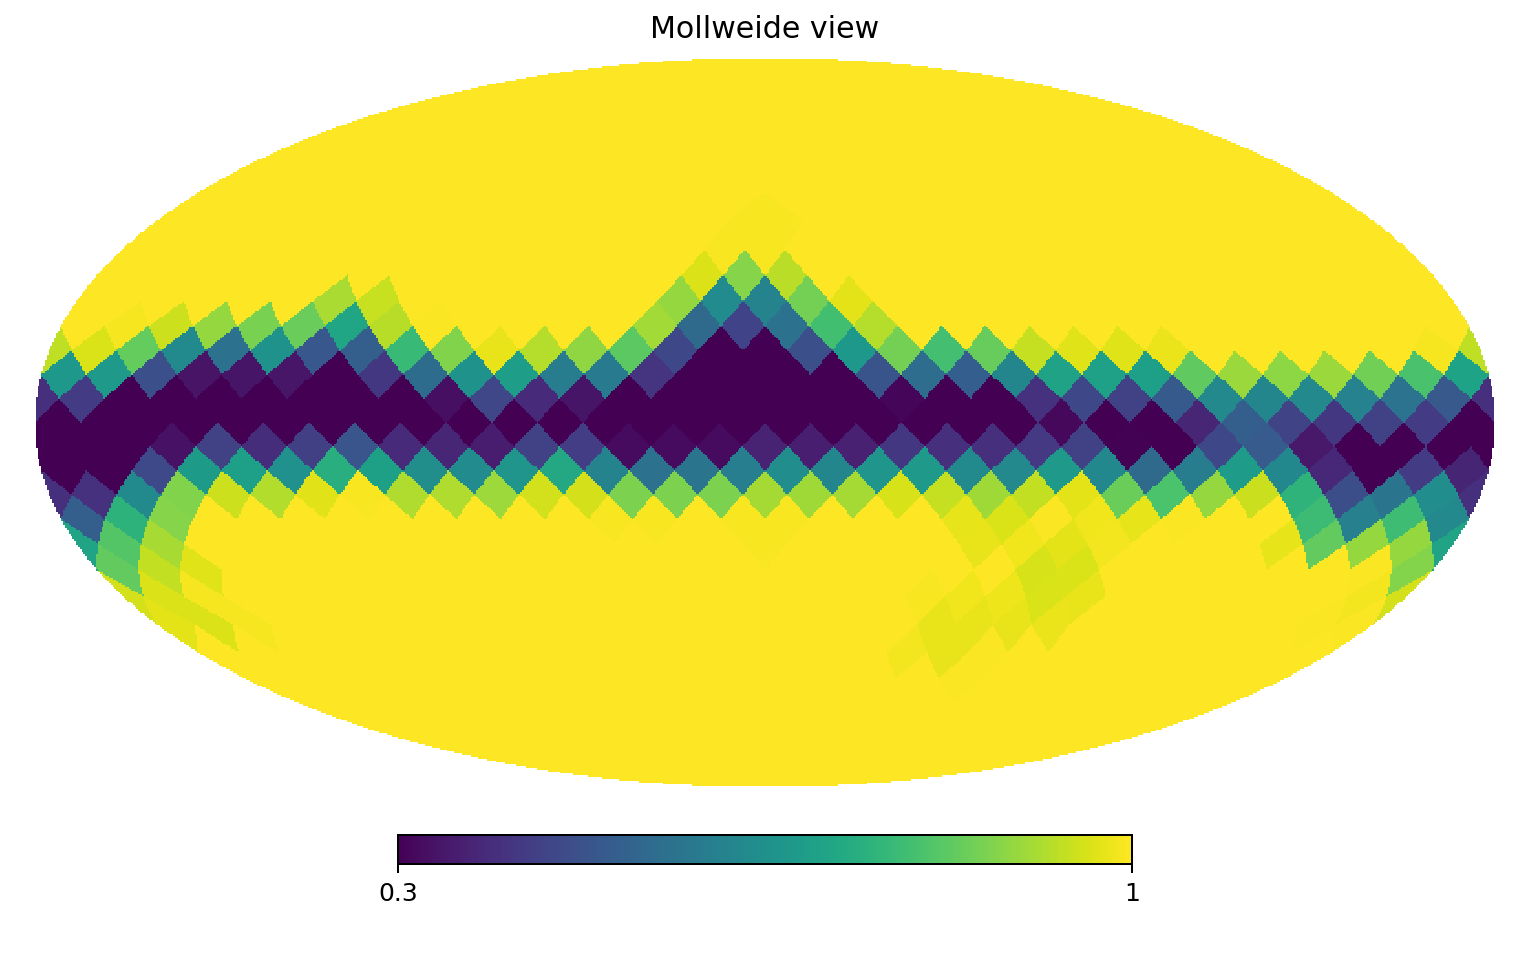

In [278]:
temp=np.copy(fsky)
temp[fsky<0.3]=0.
h.mollview(temp,min=0.3)

In [279]:
projop.pixel_size

3.435486411817406

<IPython.core.display.Javascript object>


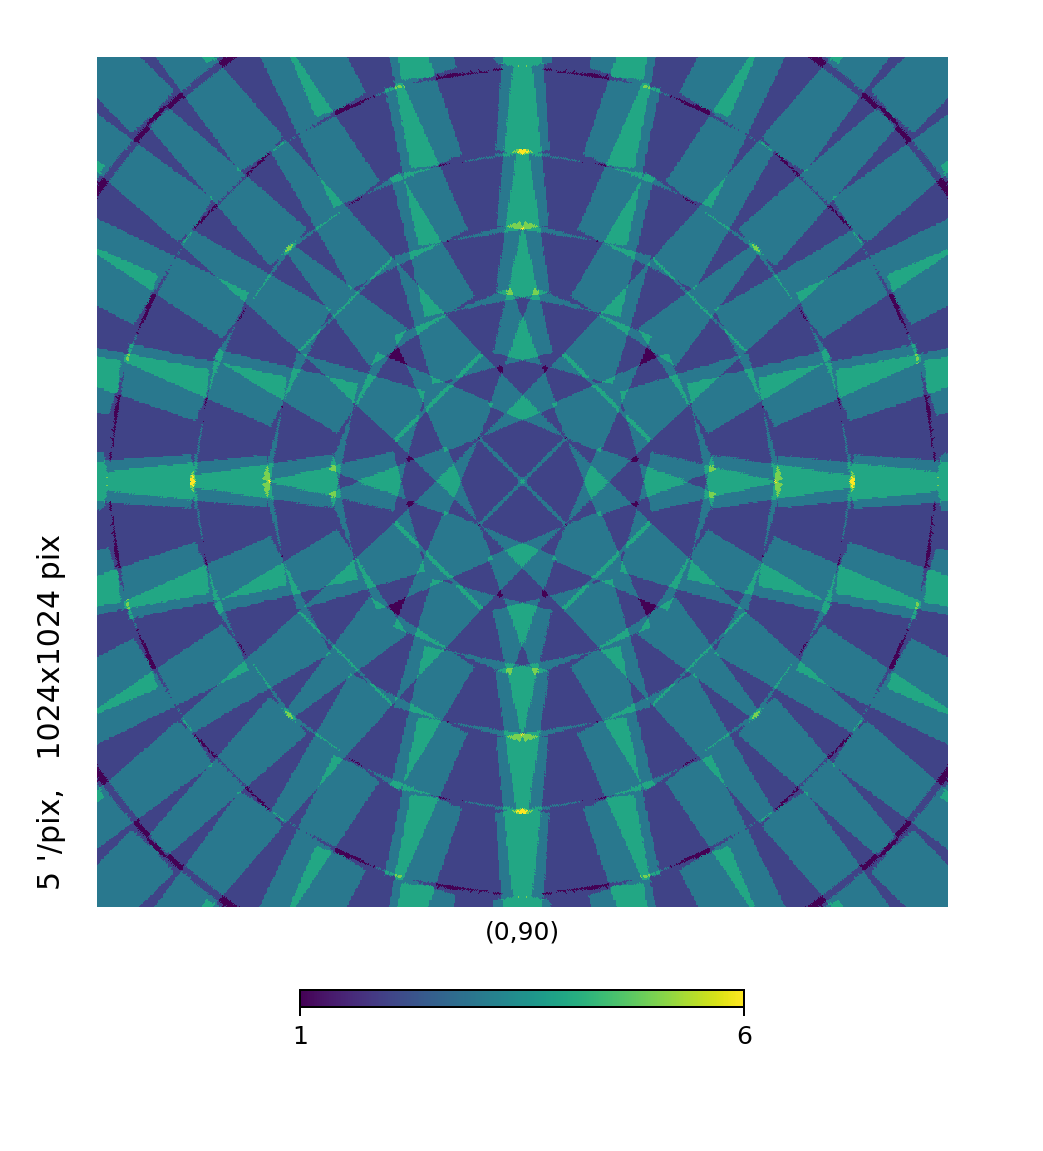

<IPython.core.display.Javascript object>


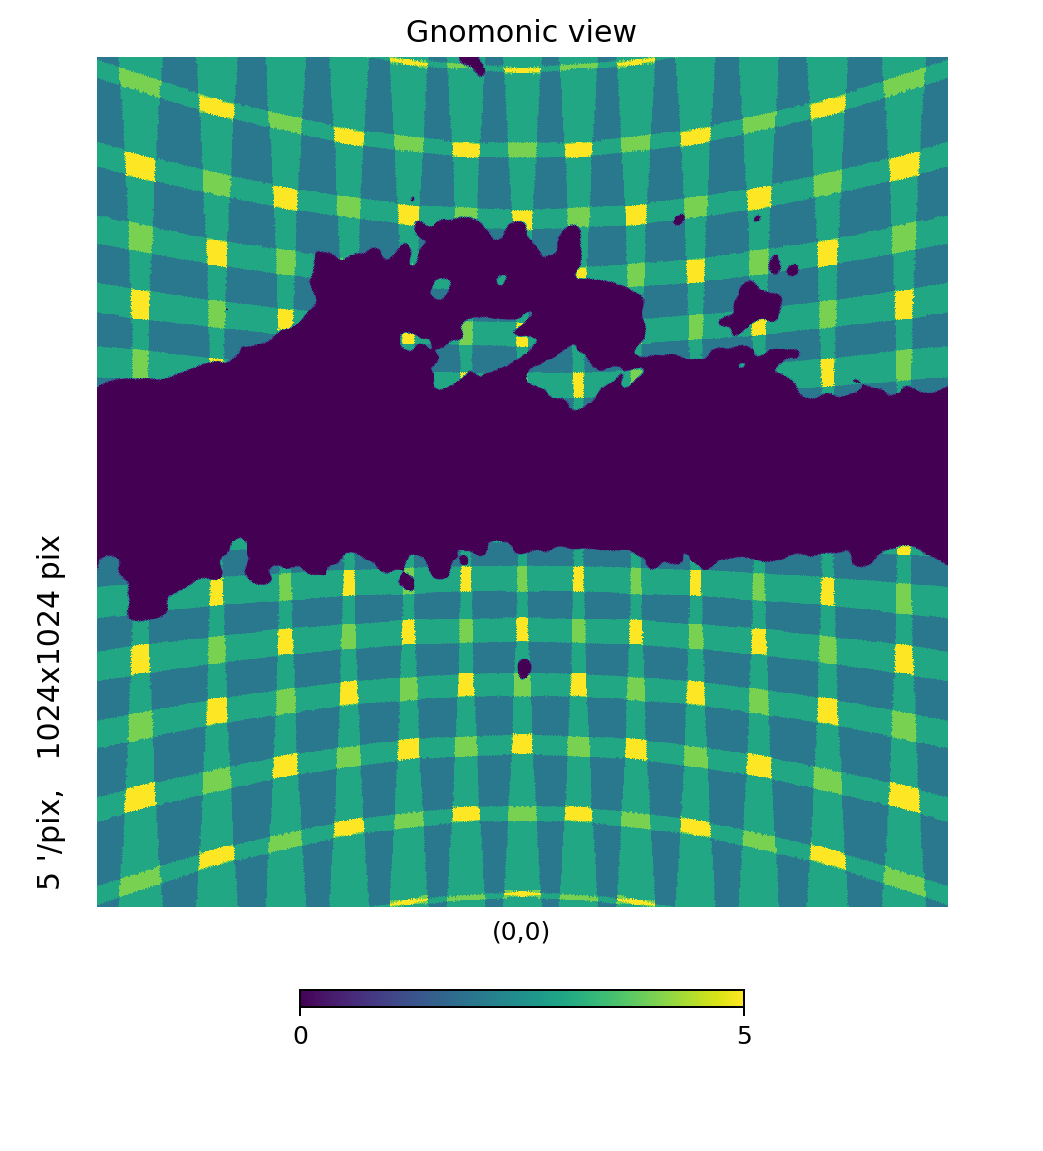

<IPython.core.display.Javascript object>


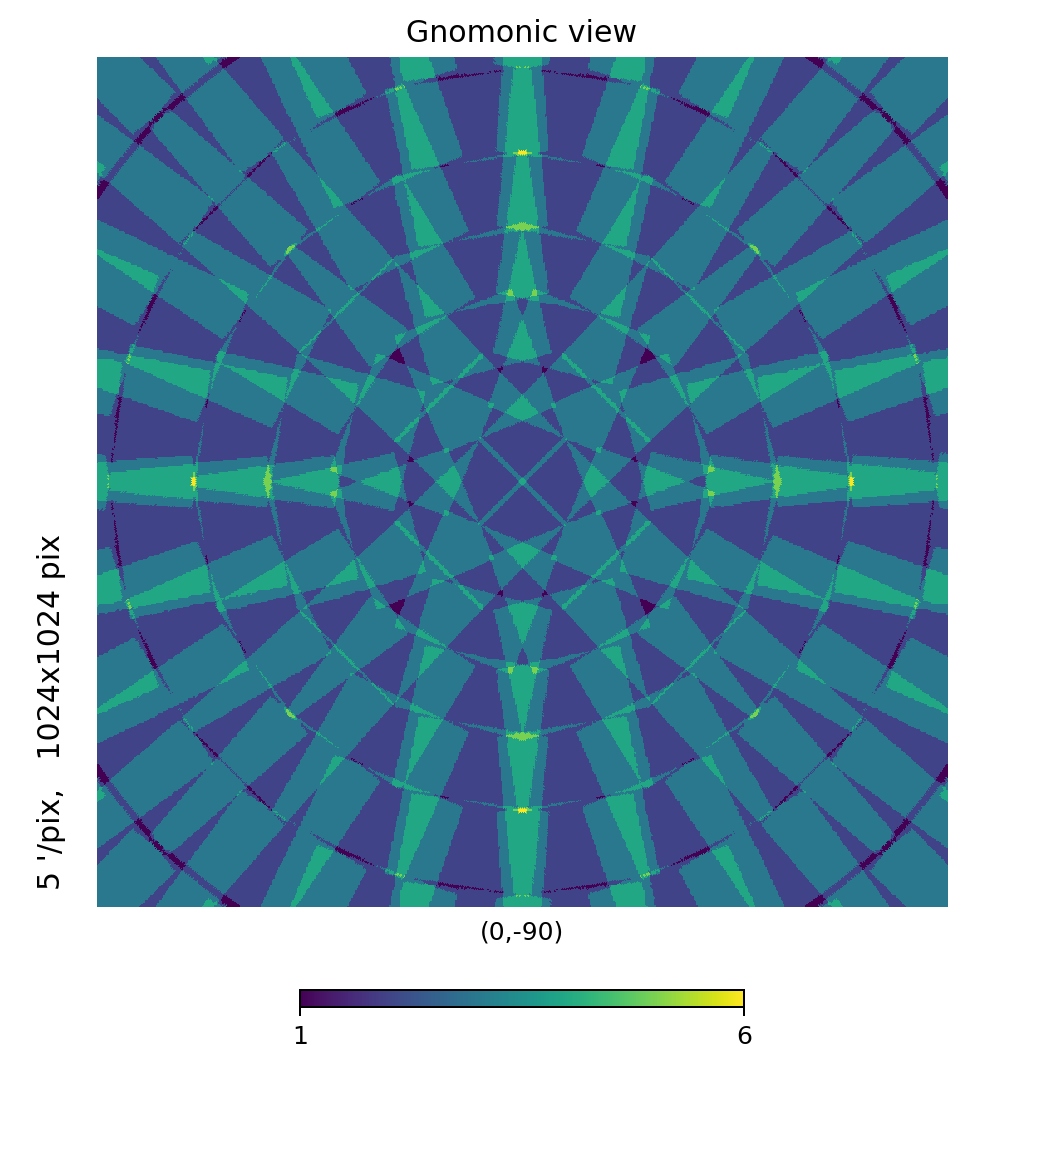

In [19]:
h.gnomview(fmap,xsize=1024,reso=5,rot=(0,90),title="")
filename=figpath + "tiled_sky_npole.pdf"
savefig(filename,bbox_inches="tight")
h.gnomview(fmap,xsize=1024,reso=5,rot=(0,0))
filename=figpath + "tiled_sky_eq.pdf"
savefig(filename,bbox_inches="tight")
h.gnomview(fmap,xsize=1024,reso=5,rot=(0,-90))
filename=figpath + "tiled_sky_spole.pdf"
savefig(filename,bbox_inches="tight")

<IPython.core.display.Javascript object>


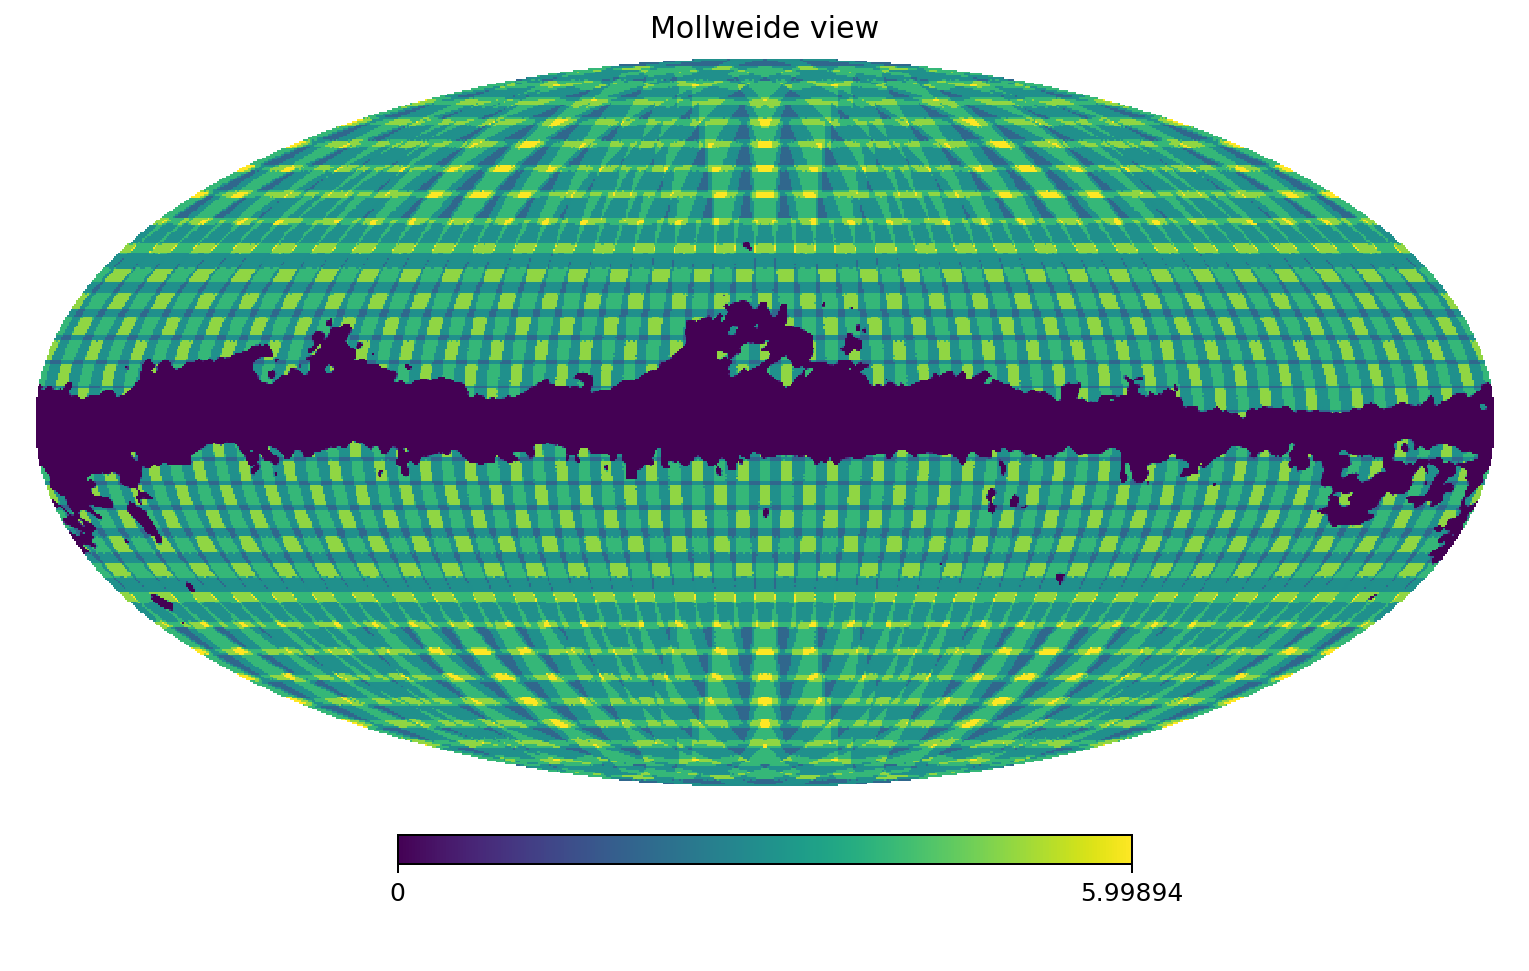

In [201]:
h.mollview(fmap,rot=(0,0))

In [281]:
tmap=np.zeros_like(fmap)
tmap[fmap*mask>0.]=1.
t1map=np.copy(fmap)
t1map[fmap<=0.]=0.

<IPython.core.display.Javascript object>


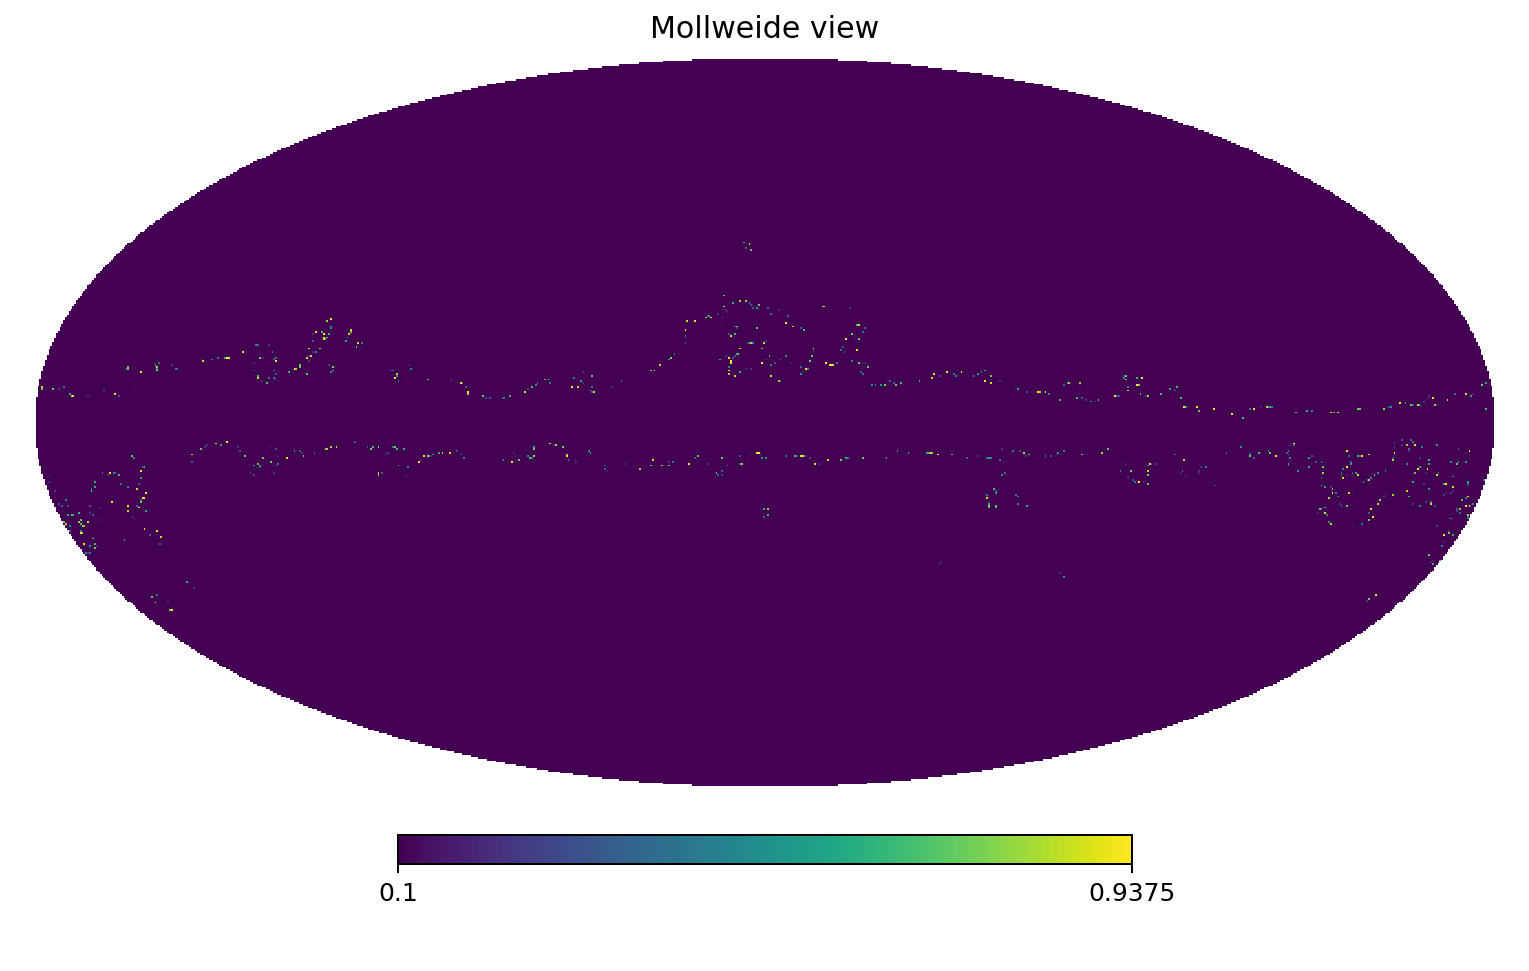

In [283]:
h.mollview(tmap-mask,min=0.1)

In [359]:
cglat=linspace(-90,90,15)
cglat=linspace(-90,90,15)

In [360]:
idx=200
filename="tile_G" + str(round(pix_glon[idx],2)) + ["", "+"][pix_glat[idx] >= 0] + str(round(pix_glat[idx],2))

In [361]:
filename

'tile_G275.63+30.0'

In [362]:
sign(pix_glat[idx])

1.0

In [116]:
lon,lat=h.pix2ang(8,0,lonlat=True)
neigh_pix=h.get_all_neighbours(8,lonlat=True,theta=lon,phi=lat)

In [117]:
lon,lat=h.pix2ang(8,neigh_pix,lonlat=True)

In [120]:
neigh_pix

array([ 4, 11,  3,  2,  1,  6,  5, 13])

In [119]:
lat

array([78.28414761, 78.28414761, 84.14973294, 84.14973294, 84.14973294,
       78.28414761, 78.28414761, 72.38756093])